In [8]:
# Load the LDA model
import pickle
with open('lda_model.pkl', 'rb') as file:
    lda_model = pickle.load(file)

# Load the Autoencoder model
from keras.models import load_model
autoencoder_model = load_model('autoencoder2_model.h5')

# Now you can use these models in your ensemble


In [9]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from keras.models import Model

# Load test data
test_data = pd.read_csv('test_LDA1.csv')
X_test = test_data.drop('Label', axis=1)  # Assuming 'Label' is your target column

# Define the selected features
selected_features = [
    'Dst Port', 'Fwd Packet Length Max', 'Bwd Packet Length Max',
    'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Mean',
    'Fwd IAT Std', 'Bwd IAT Mean', 'Fwd PSH Flags', 'Bwd PSH Flags',
    'Fwd RST Flags', 'Fwd Header Length', 'Packet Length Max',
    'Packet Length Std', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg',
    'ICMP Type'
]

# Define your anomaly threshold after proper analysis
anomaly_threshold = 31.2

def ensemble_predict(data):
    # Ensure that the input data contains only the selected features
    data_selected = data[selected_features]
    
    # Make predictions using the autoencoder model
    reconstructed_data = autoencoder_model.predict(data_selected)
    
    # Calculate the reconstruction error
    reconstruction_error = np.mean(np.power(data_selected - reconstructed_data, 2), axis=1)
    
    # Determine anomalies based on the reconstruction error and threshold
    anomalies = reconstruction_error > anomaly_threshold
    
    lda_predictions = None
    if np.any(anomalies):
        # If there are anomalies, you can use your LDA model for further predictions
        lda_predictions = lda_model.predict(data[selected_features][anomalies])
    
    return data, anomalies, lda_predictions

data, anomalies, lda_predictions = ensemble_predict(X_test)


 100/4657 [..............................] - ETA: 7s

2023-11-29 03:58:12.804378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


4657/4657 [==============================] - 7s 1ms/step


Number of anomalies detected: 303
Indices of anomalies: [   751   1029   1158   1203   2779   2817   3230   3937   4069   4733
   4787   5592   5826   6026   6682   6826   7567   8322   8654   9064
   9416  10305  10753  12536  13434  13831  14041  14047  14289  14487
  14742  15261  15497  15939  16348  16731  17784  18104  19058  19333
  19438  20434  20437  20494  20907  21250  22529  22637  23736  23744
  23929  24033  24158  24933  25761  25971  26253  26718  26806  27176
  27498  27894  27919  28307  28686  29978  30052  30278  30304  30584
  31414  31518  32669  33025  34244  34881  35276  36743  37208  38207
  38727  39514  39670  39773  39794  39812  40060  40802  41171  41808
  42204  43286  43434  43559  44189  44369  44769  45388  45627  46557
  46838  47677  47735  48011  48445  49310  49658  49666  50858  51961
  52075  52107  53393  53675  53746  54020  54564  54588  56732  57541
  58339  58431  59101  60227  61209  61339  61554  61573  61709  62595
  62984  63181  63447

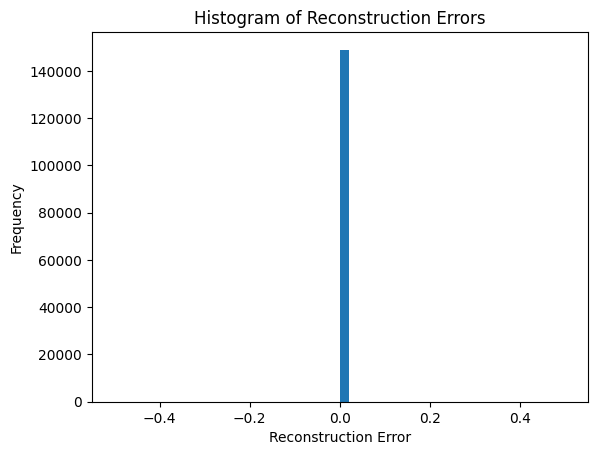

In [12]:
import matplotlib.pyplot as plt  # Import matplotlib

# Print and visualize the results
print("Number of anomalies detected:", np.sum(anomalies))
print("Indices of anomalies:", np.where(anomalies)[0])

# Simple histogram of reconstruction errors
reconstruction_error = np.mean(np.power(X_test - data, 2), axis=1)
plt.hist(reconstruction_error, bins=50)
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Histogram of Reconstruction Errors")
plt.show()

In [13]:
# Print LDA predictions
print("LDA Predictions:")
print(lda_predictions)

LDA Predictions:
['Heartbleed' 'DoS Slowloris' 'BENIGN' 'BENIGN' 'DoS Hulk' 'BENIGN'
 'BENIGN' 'BENIGN' 'BENIGN' 'Heartbleed' 'BENIGN' 'BENIGN' 'BENIGN'
 'BENIGN' 'BENIGN' 'DoS GoldenEye' 'BENIGN' 'BENIGN' 'BENIGN' 'BENIGN'
 'BENIGN' 'BENIGN' 'BENIGN' 'BENIGN' 'Heartbleed' 'BENIGN'
 'DoS GoldenEye - Attempted' 'BENIGN' 'BENIGN' 'BENIGN' 'BENIGN' 'BENIGN'
 'BENIGN' 'BENIGN' 'BENIGN' 'BENIGN' 'BENIGN' 'BENIGN' 'DoS Hulk' 'BENIGN'
 'BENIGN' 'BENIGN' 'BENIGN' 'BENIGN' 'Heartbleed' 'BENIGN' 'BENIGN'
 'BENIGN' 'Heartbleed' 'BENIGN' 'BENIGN' 'Heartbleed' 'BENIGN' 'BENIGN'
 'BENIGN' 'BENIGN' 'BENIGN' 'BENIGN' 'BENIGN' 'BENIGN' 'BENIGN' 'BENIGN'
 'BENIGN' 'DoS Hulk' 'BENIGN' 'BENIGN' 'Heartbleed' 'BENIGN' 'BENIGN'
 'Heartbleed' 'DoS Slowloris' 'BENIGN' 'BENIGN' 'BENIGN' 'Heartbleed'
 'BENIGN' 'BENIGN' 'BENIGN' 'BENIGN' 'BENIGN' 'BENIGN' 'BENIGN' 'BENIGN'
 'BENIGN' 'BENIGN' 'BENIGN' 'DoS Hulk' 'BENIGN' 'Heartbleed' 'BENIGN'
 'BENIGN' 'BENIGN' 'BENIGN' 'DoS Hulk' 'DoS Slowloris' 'BENIGN' 'BENIGN'

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming y_true is the ground truth labels for anomalies
y_true = np.where(anomalies, 1, 0)

# Assuming y_pred is the predicted labels for anomalies
y_pred = np.where(anomalies, 1, 0)  # You can replace this with your anomaly predictions

# Compute precision, recall, and F1-Score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Precision: 1.0
Recall: 1.0
F1-Score: 1.0


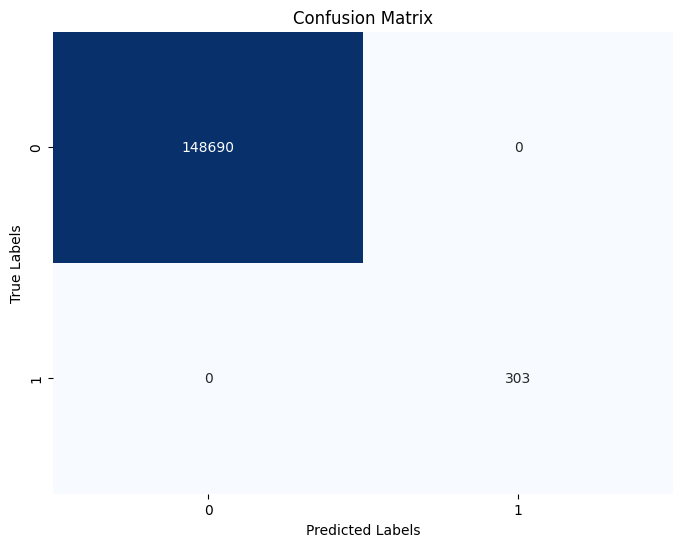

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
